## 2022 Datahacks Project Report - Intermediate

Contributors: Ziyu Wang, Zhaoyu Zhang

Goal: Predict successful deals for each company on Shark Tank tv show

Dataset: Train, Test

### ==================================================

Package Import

In [30]:
import re
import os
import csv
import nltk
import warnings
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout
from keras.models import Model
from keras.layers.embeddings import Embedding
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
warnings.filterwarnings('ignore')

### EDA

#### Data Process

In [2]:
train = pd.read_csv('./train.csv')
train.head()

,Season_Epi_code,Pitched_Business_Identifier,Pitched_Business_Desc,Deal_Status,Deal_Shark
0,826,Laid Brand,hair-care products made with pheromones . Laid...,0,NaN
1,826,Wine & Design,painting classes with wine served . Wine & Des...,1,KOL
2,824,Peoples Design,a mixing bowl with a built-in scoop . Peoples ...,1,LG
3,824,Rumi Spice,saffron imported from Afghanistan . Rumi Spice...,1,MC
4,824,Wallet Buckle,a belt buckle that holds credit cards . The Wa...,1,RH


#### Column Rename and Information

In [3]:
df = train.copy()
df.rename(columns = {'Pitched_Business_Desc':'Des', \
    'Pitched_Business_Identifier':'Brand', \
        'Season_Epi_code':'Episode',\
            'Deal_Status':'Status',\
                'Deal_Shark':'Shark'}, inplace = True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Episode  530 non-null    int64 
 1   Brand    530 non-null    object
 2   Des      530 non-null    object
 3   Status   530 non-null    int64 
 4   Shark    283 non-null    object
dtypes: int64(2), object(3)
memory usage: 20.8+ KB


In [5]:
df.head(2)

,Episode,Brand,Des,Status,Shark
0,826,Laid Brand,hair-care products made with pheromones . Laid...,0,NaN
1,826,Wine & Design,painting classes with wine served . Wine & Des...,1,KOL


<AxesSubplot:xlabel='Status', ylabel='count'>

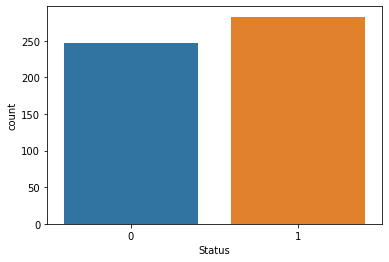

In [6]:
sns.countplot(x ='Status', data = df)

Obviously, the Description column takes most weights to predict the Status.

In [7]:
print("Null-Value Num for Desciption: " + str(df.Des.isnull().sum()))

Null-Value Num for Desciption: 0


In [8]:
df["Episode"] = df["Episode"].apply(lambda x: int(x))
print("Null-Value Num For Epi-code: " + str(df.Episode.isnull().sum()))

Null-Value Num For Epi-code: 0


#### Collect, Clean, and Standardize

In [9]:
def clean(X):
    '''Column Clean'''
    documents = []
    stemmer = WordNetLemmatizer()
    for sen in range(0, len(X)):
        # Remove special characters
        document = re.sub(r'\W', ' ', str(X[sen]))
        # remove single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
        # Substituting multiple spaces with single
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)
        # Converting to Lowercase
        document = document.lower()
        # Lemmatization
        document = document.split()
        # remove single char again of special char
        tmp = []
        for w in document:
            chs = [c for c in w if ord(c) >= 48 and ord(c) <= 122]
            w = ''.join(chs)
            tmp.append(w)
        document = tmp        
        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)
        documents.append(document)
    return documents

data_des = df.Des
data_des2 = clean(data_des)
# Sample 
"Content Demo: " + str(data_des2[0][104:])

'Content Demo: color in addition to protecting and hydrating hair  the pheromone help girl  exude confidence wherever she go'

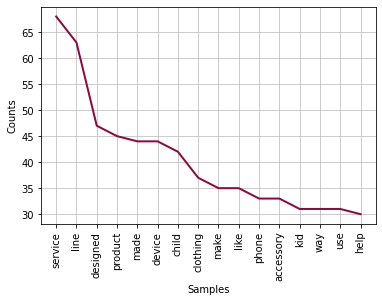

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [10]:
trash = stopwords.words('english')
text = " ".join(data_des2).lower()
stemmer = WordNetLemmatizer()
tokens = text.split()
cleans = []
for token in tokens:
    if not token in trash:
        token = stemmer.lemmatize(token)
        cleans.append(token)
freq = nltk.FreqDist(cleans)
freq.plot(16, cumulative = False, color = '#8B0A40')

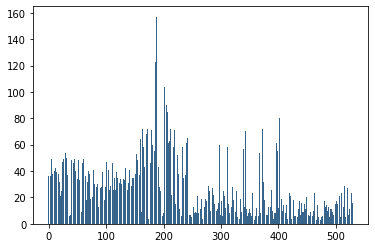

In [11]:
des_len = []
for i in data_des2:
    des_len.append(len(i.split(" ")))
plt.bar(range(len(des_len)), des_len, fc = '#36648B')
plt.show()

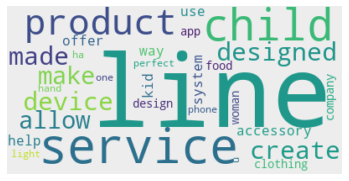

In [12]:
wordcloud = WordCloud(max_font_size = 120, max_words = 30, \
    background_color = "#EDEDED").generate(" ".join(cleans))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

From the above visualizations, the words with high frequency have normal meanings.

### Feature Enineering

### NLP Model

CountVector and XGBoost

In [13]:
len(data_des)

530

In [14]:
cv = CountVectorizer(max_features = 2000, encoding = "utf-8",  
      ngram_range = (2, 3), stop_words = 'english')

In [15]:
X = cv.fit_transform(data_des).toarray()
y = df['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, \
      test_size = 0.20, random_state = 0)
count_df = pd.DataFrame(X_train, columns = cv.get_feature_names_out())

In [16]:
count_df['tiket'] = y_train
model = XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss')
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)

print('Models with CountVector Feature:\n')
print('XGBoost Classifier Model:\n')
print('Test-set Accuracy:', accuracy)

Models with CountVector Feature:

XGBoost Classifier Model:

Test-set Accuracy: 0.5566037735849056


We found that in XGBoost Model, it reaches the best accuracy for y_test when we use the 2-gram. Furthermore, about the stopwords in English, we found that XGBoost is poor at classifying words with stop words and may do better if synonyms are processed. We are not sure whether in test data the performance will be better.

XGBoost are good at allocating rate for each tree to decrease weight, but the running is slow since it has to presort all features and generate more classifier levels.

#### TF-IDF and Decision Tree

In [17]:
dff = df.copy() # copy to prevent catastrophe

In [18]:
def TFIDFModels(Model, text):
    
    x_train, x_test, y_train, y_test = train_test_split(dff['Des'], dff['Status'],\
         test_size = 0.2, random_state = 50)
    
    vect      = TfidfVectorizer(min_df = 5, max_df = 0.7, \
        sublinear_tf = True, use_idf = True)
    train_vect= vect.fit_transform(x_train)
    test_vect = vect.transform(x_test)
    
    model     = Model
    model.fit(train_vect, y_train)
    predicted = model.predict(test_vect)
    accuracy  = model.score(train_vect, y_train)
    report = classification_report(y_test, predicted, output_dict=True)
    
    print(text)
    print('Test-set Accuracy:', accuracy_score(y_test, predicted))
    print('\n')

In [19]:
def KNN_TFIDF():
    # x, y
    x_train, x_test, y_train, y_test = train_test_split(dff['Des'], dff['Status'],\
         test_size = 0.2, random_state = 50)
    # TF-IDF
    vect      = TfidfVectorizer(min_df = 5, max_df = 0.7, \
        sublinear_tf = True, use_idf = True)
    train_vect= vect.fit_transform(x_train)
    test_vect = vect.transform(x_test)
    
    for k in [1,2]: # 1-gram, 2-gram
        model = KNeighborsClassifier(n_neighbors = k)
        model.fit(train_vect, y_train)

        predicted = model.predict(test_vect)
        accuracy  = model.score(train_vect, y_train)
        report = classification_report(y_test, predicted, output_dict=True)

        print("Classification for k = {} is:".format(k))
        print('Test-set Accuracy:', accuracy_score(y_test, predicted))
        print('\n')

In [20]:
from sklearn import svm
SupportVectorClassifier = svm.SVC(C = 2, kernel='poly')

print('Models with TF-IDF Feature:\n')

# Support Vector
svm = TFIDFModels(Model = SupportVectorClassifier,\
    text = 'Support Vector Classifier Model:\n')

# Decision Tree
DecTree = TFIDFModels(Model = tree.DecisionTreeClassifier()\
    ,text = 'Decision Tree Classifier Model:\n')
knn_tfidf = KNN_TFIDF()

Models with TF-IDF Feature:

Support Vector Classifier Model:

Test-set Accuracy: 0.6415094339622641


Decision Tree Classifier Model:

Test-set Accuracy: 0.5


Classification for k = 1 is:
Test-set Accuracy: 0.6509433962264151


Classification for k = 2 is:
Test-set Accuracy: 0.46226415094339623




We can see that Support Vector and 1-gram Decision Tree have similar performance.

#### Random Forest

In [21]:
test = pd.read_csv("./test.csv")

In [22]:
x_train, y_train = df['Des'], df['Status']
vect = CountVectorizer(max_features=1000 , ngram_range=(2,2))
vct  = vect.fit(x_train)
train_vect = vct.transform(x_train)
test_vect = vct.transform(test.Pitched_Business_Desc)
rf = RandomForestClassifier()
rf.fit(train_vect,y_train)   
y_pred = rf.predict_proba(test_vect)

In [23]:
step_factor = 0.05 
threshold = 0.2 
roc_score = 0
predicted_proba = rf.predict_proba(train_vect) # probability of prediction
while threshold <= 0.8: # check best threshold 
    temp_thresh = threshold
    predicted = (predicted_proba [:,1] >= temp_thresh).astype('int')
    print('Threshold', round(temp_thresh, 2), \
    '-- score', round(roc_auc_score(y_train, predicted), 2))
    if roc_score < roc_auc_score(y_train, predicted): #store the threshold for best classification
        roc_score = roc_auc_score(y_train, predicted)
        thrsh_score = threshold
    threshold = threshold + step_factor
print('---Optimum Threshold ---', thrsh_score, \
    '--ROC--', round(roc_score,2))

Threshold 0.2 -- score 0.76
Threshold 0.25 -- score 0.85
Threshold 0.3 -- score 0.9
Threshold 0.35 -- score 0.93
Threshold 0.4 -- score 0.94
Threshold 0.45 -- score 0.94
Threshold 0.5 -- score 0.95
Threshold 0.55 -- score 0.95
Threshold 0.6 -- score 0.95
Threshold 0.65 -- score 0.95
Threshold 0.7 -- score 0.94
Threshold 0.75 -- score 0.92
---Optimum Threshold --- 0.49999999999999994 --ROC-- 0.95


We pick 0.6 as from 0.55-0.7 performs roughly same.

In [24]:
y_pred = y_pred[:, 1]
rf_out = []
for i in range(len(y_pred)):
  if y_pred[i] >= 0.6:
    rf_out.append(1)
  else:
    rf_out.append(0)
rf_output = pd.DataFrame(rf_out)
rf_out[:10]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

#### LSTM


In [25]:
data2 = pd.read_csv('train.csv')
data2.rename(columns = {'Pitched_Business_Desc':'Des', \
    'Pitched_Business_Identifier':'Brand', \
        'Season_Epi_code':'Episode',\
            'Deal_Status':'Status',\
                'Deal_Shark':'Shark'}, inplace = True)
data2 = data2[['Des','Status']]
data2['Des'] = clean(data2['Des'])

In [26]:
X, y = data2['Des'], data2['Status']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = np.array(X)
y = np.array(y)
# pad sequences at the beginning of each sequence with 0's
# for example if SEQUENCE_LENGTH=4:
# [[5, 3, 2], [5, 1, 2, 3], [3, 4]]
# will be transformed to:
# [[0, 5, 3, 2], [5, 1, 2, 3], [0, 0, 3, 4]]
X = pad_sequences(X, maxlen = 100)
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, \
    test_size = 0.2, random_state=7)

In [27]:
def get_model(tokenizer, lstm_units):
    """
    Constructs the model
    """
    # get the GloVe embedding vectors
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index)+1,
              100,
              trainable=False,
              input_length= 100))

    model.add(LSTM(lstm_units, recurrent_dropout=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation="softmax"))
    # compile as rmsprop optimizer
    # aswell as with recall metric
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy",
                  metrics=["accuracy"])
    model.summary()
    return model

In [28]:
model = get_model( tokenizer = tokenizer, lstm_units = 128)
model.fit(X_train, y_train, validation_data = (X_test, y_test),
          batch_size=16, epochs=12, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          340700    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 458,206
Trainable params: 117,506
Non-trainable params: 340,700
_________________________________________________________________
Epoch 1/12
27/27 [==============================] - 5s 84ms/step - loss: 0.6922 - accuracy: 0.5425 - val_loss: 0.6999 - val_accuracy: 0.4340
Epoch 2/12
27/27 [=================

In [29]:
result = model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 15ms/step - loss: 0.7650 - accuracy: 0.5000


We found that LSTM does not perform so well in the small dataset. The reason is not clear but we did not have enough time to embed vectors which may affect accuracy.

From above, we decide to use TF-IDF that perform slightly better in train set.

In [31]:
test = pd.read_csv("./test.csv")
vect      = TfidfVectorizer(min_df = 5, max_df = 0.8,\
    sublinear_tf = True, use_idf = True)
train_vect= vect.fit_transform(df['Des'])
test_vect = vect.transform(test.Pitched_Business_Desc)
SupportVectorClassifier.fit(train_vect, df['Status'])
predicted = SupportVectorClassifier.predict(test_vect)
tf_out = pd.DataFrame(predicted)
tf_out.rename(columns = {0:'Pred'}, inplace = True)
tf_out.head()
file = 'output.csv'
if(os.path.exists(file) and os.path.isfile(file)):
    os.remove(file)
tf_out.to_csv('output.csv', index = False)
print("Prediction saved.")


Prediction saved.
